In [57]:
import numpy as np
from PIL import Image, ImageFilter

import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

In [9]:
def generate_center_white_image(width=256, height=256, central_ratio=0.75):
    """
    Generate an image where the central `central_ratio` portion is white 
    and the rest is black.

    Args:
        width (int): Width of the image.
        height (int): Height of the image.
        central_ratio (float): Fraction (0 < central_ratio < 1) of both width and height 
                               that should be white in the center.

    Returns:
        PIL.Image: The generated image.
    """
    assert 0 < central_ratio < 1, "central_ratio must be between 0 and 1"
    
    # Create a black image
    image = np.zeros((height, width), dtype=np.uint8)
    
    # Calculate margins for the central white rectangle
    margin_x = int(width * (1 - central_ratio) / 2)
    margin_y = int(height * (1 - central_ratio) / 2)
    
    # Define the white central region
    image[margin_y:height - margin_y, margin_x:width - margin_x] = 255

    return Image.fromarray(image)

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    # "runwayml/stable-diffusion-v1-5",
    "runwayml/stable-diffusion-inpainting", 
    # "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",  # duży
    # "kandinsky-community/kandinsky-2-2-decoder-inpaint", # duży
    torch_dtype=torch.float16, variant="fp16"
)

pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

Fetching 18 files:  11%|█         | 2/18 [00:00<00:02,  5.90it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


In [89]:
init_image = Image.open("image.jpg")
init_image = init_image.resize((512, 512))

In [97]:
mask_image = generate_center_white_image(init_image.size[0], init_image.size[1], central_ratio=0.55)
# blurred_mask = pipeline.mask_processor.blur(mask_image, blur_factor=33)

In [98]:
# blurred_mask = mask_image.filter(ImageFilter.GaussianBlur(radius=33))

100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


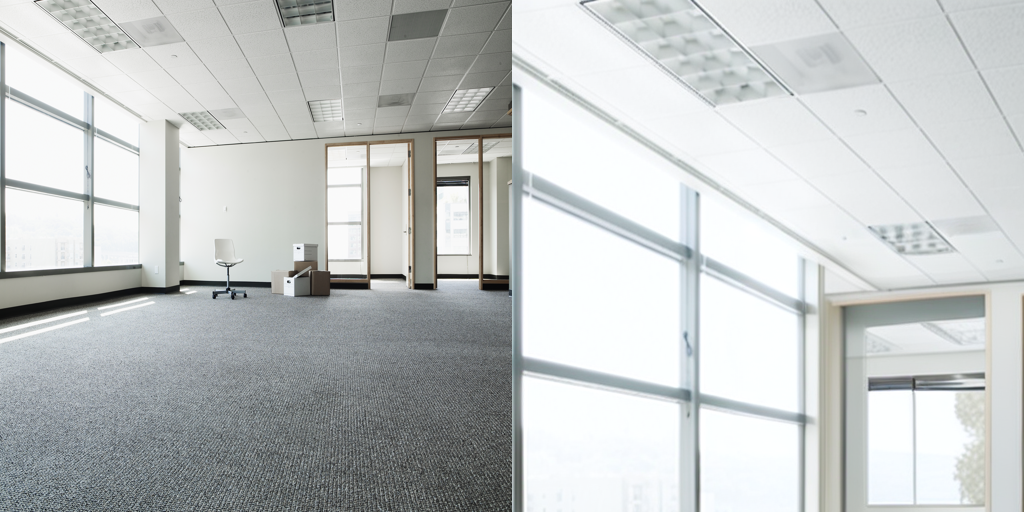

In [99]:
generator = torch.Generator("cuda").manual_seed(92)
prompt = "Office with 3 desks and pool table"
# negative_prompt = "changing image background"
#  strength=0.7, guidance_scale=12.5
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, generator=generator).images[0]
make_image_grid([init_image, image], rows=1, cols=2)